In [7]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, QuantileTransformer, PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, mean_absolute_error

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./kaggle/input\sf-dst-scoring\sample_submission.csv
./kaggle/input\sf-dst-scoring\test.csv
./kaggle/input\sf-dst-scoring\train.csv


In [2]:
# Информация о выбросах
def outlines_info(column):
    # график
    plt.figure();
    sns.boxplot(column);
    plt.show();
    # выбросы
    q1, q3 = np.percentile(column, [25, 75])
    iqr = q3 - q1
    low_bound = q1 - (iqr * 1.5)
    up_bound = q3 + (iqr * 1.5)
    print(low_bound, up_bound)
    print("Процент значений за границей: {}%".format(len(column[((column > up_bound) | (column < low_bound))])* 100/len(column)))

In [3]:
# Граничные значения по колонке
def get_bounds(column):
    q1, q3 = np.percentile(column, [25, 75])
    iqr = q3 - q1
    low_bound = q1 - (iqr * 1.5)
    up_bound = q3 + (iqr * 1.5)
    return low_bound, up_bound

In [4]:
# Удаление выбросов
def remove_outlines(df, column):
    low_bound, up_bound = get_bounds(df[column])
    print(len(df))
    return df.loc[df[column].between(low_bound, up_bound)]

In [5]:
# Зафиксируем версию пакетов и random_seed, для воспроизводимости эксперимента
!pip freeze > requirements.txt
random_seed = 31


In [8]:
df_test = pd.read_csv("./kaggle/input/sf-dst-scoring/test.csv")
df_train = pd.read_csv("./kaggle/input/sf-dst-scoring/train.csv")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Описание данных
```
client_id                идентификатор клиента
education                уровень образования
sex                      пол заёмщика
age                      возраст заёмщика
car                      флаг наличия автомобиля
car_type                 флаг автомобиля-иномарки
decline_app_cnt          количество отказанных прошлых заявок
good_work                флаг наличия «хорошей» работы
bki_request_cnt          количество запросов в БКИ
home_address             категоризатор домашнего адреса
work_address             категоризатор рабочего адреса
income                   доход заёмщика
foreign_passport         наличие загранпаспорта
sna                      связь заемщика с клиентами банка
first_time               давность наличия информации о заемщике
score_bki                скоринговый балл по данным из БКИ
region_rating            рейтинг региона
app_date                 дата подачи заявки
default                  наличие дефолта
```

Целевая переменная:

`default`

Признаки c пропусками:

`education`

Бинарные переменные:

```
sex
car
car_type
foreign_passport
good_work
```

Категориальные переменные:

```
education
work_address
home_address
sna
first_time
region_rating
app_date
```

Числовые переменные:
```
age
decline_app_cnt
income
bki_request_cnt
score_bki
```

In [ ]:
# Посмотрим выборку на сбалансированность

df_train.default.value_counts().plot.barh();

Клиентов без дефолта у банка значительно больше. Выборка несбалансированна, но мы можем попробовать это компенсировать с помощью гиперпараметра логистической регрессии `class_weight`

## 1. Предобработка данных

### Заполнение пропусков

In [ ]:
# Посмотрим на столбец с пропусками

df_train.education.value_counts(dropna=False)

Значений с пропусками немного, но все же в 1.5 раза больше, чем со значением 'ACD'. Скорее всего, заполнив наиболее часто встречающимся значением 'SCH' мы потерям часть информации. Поэтому создадим новый признак 'NAN_EDU'

In [ ]:
df_train.education.fillna('NAN_EDU',inplace=True)
df_test.education.fillna('NAN_EDU',inplace=True)

### Подготовка данных для обучения модели

Разделим столбцы по типам переменных

In [ ]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time', 'region_rating']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']

Посмотрим на распределение числовых переменных

In [ ]:
for i in num_cols:
    plt.figure()
    sns.distplot(df_train[i], kde = False, rug=False, bins = 100)
    plt.title(i)
    plt.show()

После построения гистограмм стало видно, что распределения числовых переменных `income`, `bki_request_count`, `decline_app_cnt`, `age` смещены влево от нормального распределения. Чтобы сделать распределение более нормальным, можно работать с логарифмированными величинами этих переменных. `score_bki` распределен нормально, поэтому преобразование не требуется.

In [ ]:
df_train.income = np.log(df_train.income)
df_train.age = np.log(df_train.age)
df_train.bki_request_cnt = np.log(df_train.bki_request_cnt + 1) # +1 для предотвращения взятия логарифма от 0
df_train.decline_app_cnt = np.log(df_train.decline_app_cnt + 1)

### Выбросы

In [ ]:
for column in num_cols:
    outlines_info(df_train[column]);

Очистим выбросы там, где их меньше 5% `score_bki`, `income` и `bki_request_cnt`

In [ ]:
df_train = remove_outlines(df_train, "score_bki")
df_train = remove_outlines(df_train, "income")
df_train = remove_outlines(df_train, "bki_request_cnt")

### Корреляция

Оценим корреляцию Пирсона для непрерывных переменных по формуле:

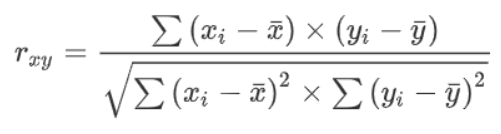

In [ ]:
plt.subplots(figsize=(10, 7))
sns.heatmap(df_train[num_cols].corr().abs(), vmin=0, vmax=1);

Взаимосвязь пар числовых признаков по Пирсону слабая, поэтому убирать ничего не нужно

### Значимость числовых признаков

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

Возможности модуля sklearn.feature_selection могут быть использованы не только для выбора важных признаков, но и для уменьшения размерности, улучшения предсказательной силы моделей, либо для повышения их производительности на очень многомерных наборах данных.

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

In [ ]:
imp_num = Series(f_classif(df_train[num_cols], df_train.default)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

Наименее важным признаком оказался возраст

In [ ]:
# Преобразуем бинарные признаки с помощью LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df_train[column] = label_encoder.fit_transform(df_train[column])
df_train

In [ ]:
for column in bin_cols:
    df_test[column] = label_encoder.fit_transform(df_test[column])
df_test

In [ ]:
# Преобразуем категориальные признаки с помощью OneHotEncoder

X_cat = OneHotEncoder(sparse = False).fit_transform(df_train[cat_cols].values)
df_train

In [ ]:
X_cat_test = OneHotEncoder(sparse = False).fit_transform(df_test[cat_cols].values)

Признак `app_date` тоже категориальный, но преобразование с помощью OneHotEncoder обесценит информацию от него

In [ ]:
# Преобразуем строку в datetime формат
df_train.app_date = pd.to_datetime(df_train.app_date, format='%d%b%Y')
# Заменим app_date на количество дней с первой даты в данных
min_date = df_train.app_date.min()
df_train['app_date'] = (df_train.app_date - min_date).dt.days.astype('int')
df_train

In [ ]:
# Аналогично для тестовой

df_test.app_date = pd.to_datetime(df_test.app_date, format='%d%b%Y')
min_date = df_test.app_date.min()
df_test['app_date'] = (df_test.app_date - min_date).dt.days.astype('int')
df_test

In [ ]:
df_train.education = label_encoder.fit_transform(df_train.education)
df_test.education = label_encoder.fit_transform(df_test.education)

### Значимость для категориальных признаков

In [ ]:
imp_cat = Series(mutual_info_classif(df_train[bin_cols + cat_cols], df_train['default'], discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

Признаки `sex`, `car`,`good_work` являются наименее важными

In [ ]:
# Стандартизация числовых переменных
X_num_train = StandardScaler().fit_transform(df_train[num_cols].values)
# Объединяем
X = np.hstack([X_num_train, df_train[bin_cols].values, X_cat])
Y = df_train['default'].values

In [ ]:
X_num_test = StandardScaler().fit_transform(df_test[num_cols].values)
X_test = np.hstack([X_num_test, df_test[bin_cols].values, X_cat_test])

Удалим наименее значимые признаки `sex` и `age`

In [ ]:
df_train.drop(['sex', 'age'], axis='columns', inplace=True)
df_train

## Построение модели

In [ ]:
# Разделим данные для проверки модели

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=random_seed)

In [ ]:
# Создаём модель
model = LogisticRegression()

# Обучаем модель на тестовом наборе данных
model.fit(x_train,y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
probs = model.predict_proba(x_test)
probs = probs[:,1]

In [ ]:
# Сравниваем предсказанные значения (probs) с реальными (y_test)
fpr, tpr, threshold = roc_curve(y_test, probs)

roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### Подбор гиперпараметров

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

multi_class = ['auto', 'ovr', 'multinomial']

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty, multi_class=multi_class)

model = LogisticRegression(random_state=random_seed)
model.fit(x_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(x_train, y_train)

# Показать лучшие гиперпараметры
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
print('Лучшее multi_class:', best_model.best_estimator_.get_params()['multi_class'])

## Модель с подобранными гиперпараметрами

In [ ]:
model = LogisticRegression(penalty='l2', C=7.742636826811269, multi_class='multinomial', random_state=random_seed)
model.fit(X, Y)

probs = model.predict(X_test)

In [ ]:
submission = pd.DataFrame()
submission['client_id'] = df_test['client_id']
submission['default'] = probs
submission.to_csv('submission.csv', index=False)
submission